# **import library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import itertools
warnings.filterwarnings('ignore')


## **Import Dataset**

In [2]:
# Load the datasets
jj_df = pd.read_csv("jj.csv")
amzn_df = pd.read_csv("AMZN.csv")


## **Date Time Format**

In [3]:

# Convert date columns to DateTime format and set as index
jj_df["date"] = pd.to_datetime(jj_df["date"])
jj_df.set_index("date", inplace=True)

amzn_df["Date"] = pd.to_datetime(amzn_df["Date"])
amzn_df.set_index("Date", inplace=True)


## **Analysis**

In [4]:

# Display basic information about the datasets
jj_info = jj_df.info()
amzn_info = amzn_df.info()

# Display the first few rows
jj_head = jj_df.head()
amzn_head = amzn_df.head()

jj_info, jj_head, amzn_info, amzn_head

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 1960-01-01 to 1980-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    84 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-02-20 to 2023-02-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


(None,
             data
 date            
 1960-01-01  0.71
 1960-04-01  0.63
 1960-07-02  0.85
 1960-10-01  0.44
 1961-01-01  0.61,
 None,
                  Open       High        Low      Close  Adj Close     Volume
 Date                                                                        
 2018-02-20  72.324501  74.438499  72.324501  73.417503  73.417503  129984000
 2018-02-21  74.250000  75.174500  73.945999  74.146004  74.146004  126088000
 2018-02-22  74.767998  75.126999  73.788002  74.266998  74.266998   97162000
 2018-02-23  74.766998  75.000000  74.324997  75.000000  75.000000   88362000
 2018-02-26  75.459999  76.141998  75.349998  76.097504  76.097504   99100000)

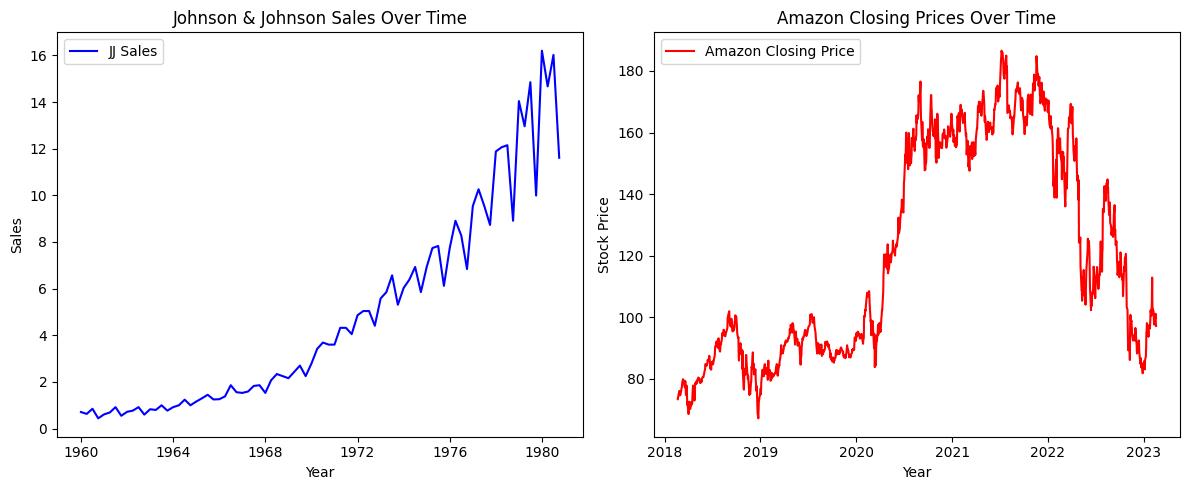

In [5]:

# Plot time series
plt.figure(figsize=(12, 5))

# Johnson & Johnson sales data
plt.subplot(1, 2, 1)
plt.plot(jj_df["data"], label="JJ Sales", color="blue")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Johnson & Johnson Sales Over Time")
plt.legend()

# Amazon stock closing prices
plt.subplot(1, 2, 2)
plt.plot(amzn_df["Close"], label="Amazon Closing Price", color="red")
plt.xlabel("Year")
plt.ylabel("Stock Price")
plt.title("Amazon Closing Prices Over Time")
plt.legend()

plt.tight_layout()
plt.show()

#**ADF TEST**

In [6]:


# ADF Test Function
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print("-" * 40)

# Perform ADF test on original datasets
adf_test(jj_df["data"], "Johnson & Johnson Sales")
adf_test(amzn_df["Close"], "Amazon Stock Prices")


ADF Test for Johnson & Johnson Sales:
ADF Statistic: 2.7420
p-value: 1.0000
Non-Stationary
----------------------------------------
ADF Test for Amazon Stock Prices:
ADF Statistic: -1.6578
p-value: 0.4530
Non-Stationary
----------------------------------------


In [7]:

# Differencing to make data stationary
jj_df_diff = jj_df["data"].diff().dropna()
amzn_df_diff = amzn_df["Close"].diff().dropna()

# Re-run ADF test after differencing
adf_test(jj_df_diff, "Johnson & Johnson Sales (Differenced)")
adf_test(amzn_df_diff, "Amazon Stock Prices (Differenced)")

# Plot ACF & PACF to determine p and q values
def plot_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, ax=axes[0])
    plot_pacf(series, ax=axes[1])
    axes[0].set_title(f"ACF - {title}")
    axes[1].set_title(f"PACF - {title}")
    plt.show()


ADF Test for Johnson & Johnson Sales (Differenced):
ADF Statistic: -0.4074
p-value: 0.9089
Non-Stationary
----------------------------------------
ADF Test for Amazon Stock Prices (Differenced):
ADF Statistic: -36.2508
p-value: 0.0000
Stationary
----------------------------------------


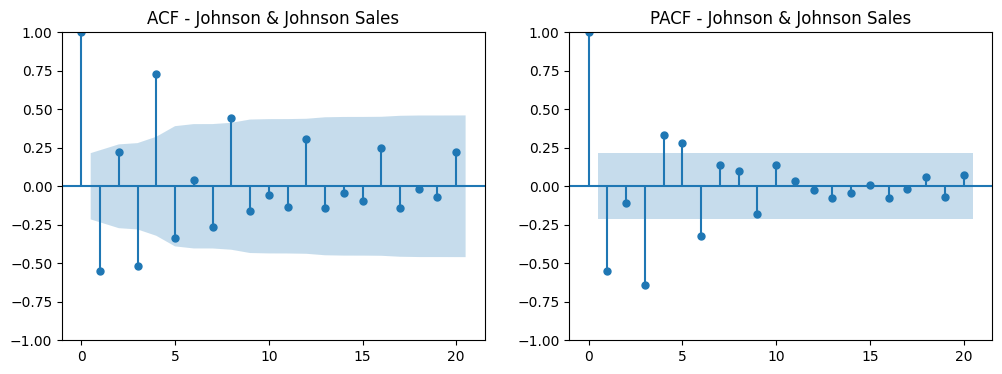

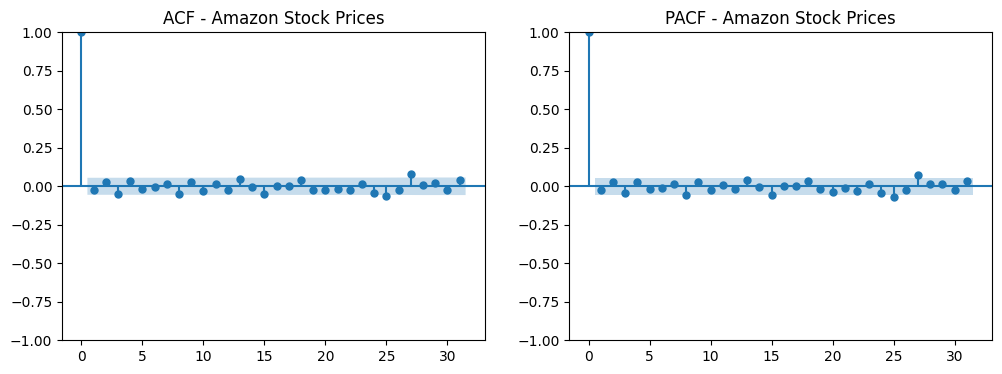

In [8]:

plot_acf_pacf(jj_df_diff, "Johnson & Johnson Sales")
plot_acf_pacf(amzn_df_diff, "Amazon Stock Prices")


# **ARIMA MODEL**

Best ARIMA(3, 1, 3) AIC: 166.57
Best ARIMA(2, 1, 2) AIC: 6122.32
Johnson & Johnson Evaluation:
MSE: 0.95, MAE: 0.81
Amazon Evaluation:
MSE: 8.91, MAE: 2.17


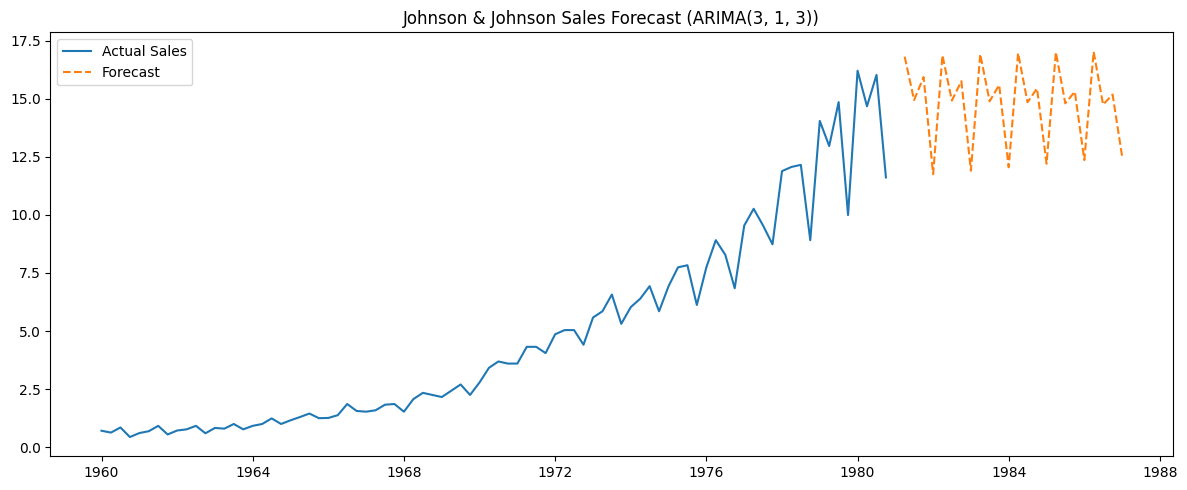

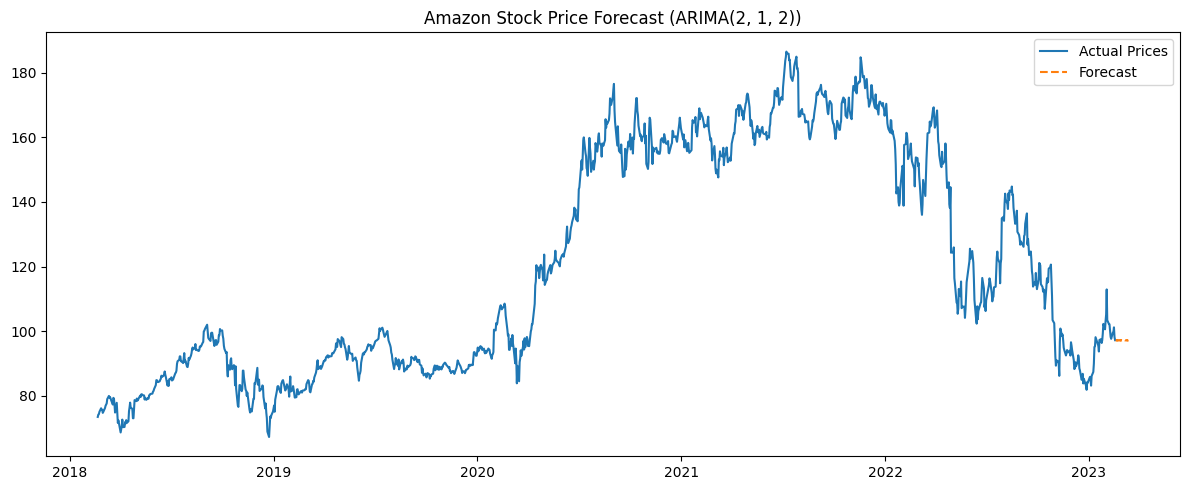

Forecasting complete!


In [9]:
# Function to find best ARIMA order
from statsmodels.tsa.statespace.sarimax import SARIMAX

def find_best_arima(series, d):
    p = q = range(0, 4)
    pdq = list(itertools.product(p, [d], q))
    best_aic = float("inf")
    best_order = None
    best_model = None

    for order in pdq:
        try:
            model = SARIMAX(series, order=order).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue

    print(f"Best ARIMA{best_order} AIC: {best_aic:.2f}")
    return best_model, best_order

# Find best ARIMA models
jj_model, jj_order = find_best_arima(jj_df["data"], d=1)
amzn_model, amzn_order = find_best_arima(amzn_df["Close"], d=1)

# Forecast 24 months
jj_forecast = jj_model.forecast(steps=24)
amzn_forecast = amzn_model.forecast(steps=24)

# Evaluation metrics (on last 24 points of train set vs predicted)
def evaluate_model(model, data, steps):
    pred = model.get_prediction(start=-steps)
    pred_mean = pred.predicted_mean
    truth = data[-steps:]
    mse = mean_squared_error(truth, pred_mean)
    mae = mean_absolute_error(truth, pred_mean)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")

print("Johnson & Johnson Evaluation:")
evaluate_model(jj_model, jj_df["data"], steps=24)

print("Amazon Evaluation:")
evaluate_model(amzn_model, amzn_df["Close"], steps=24)

# Plot forecasts
plt.figure(figsize=(12, 5))
plt.plot(jj_df.index, jj_df["data"], label="Actual Sales")
plt.plot(pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:], jj_forecast, label="Forecast", linestyle='dashed')
plt.legend()
plt.title(f"Johnson & Johnson Sales Forecast (ARIMA{jj_order})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(amzn_df.index, amzn_df["Close"], label="Actual Prices")
plt.plot(pd.date_range(amzn_df.index[-1], periods=25, freq='D')[1:], amzn_forecast, label="Forecast", linestyle='dashed')
plt.legend()
plt.title(f"Amazon Stock Price Forecast (ARIMA{amzn_order})")
plt.tight_layout()
plt.show()

print("Forecasting complete!")


# **RNN MODEL**

In [13]:
# Prepare data for RNNs

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [14]:
# Enhanced LSTM/GRU model builder with  layers

def build_rnn_model(units=50, rnn_type="LSTM", input_shape=(12, 1)):
    model = Sequential()
    if rnn_type == "LSTM":
        model.add(LSTM(units, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(units, activation='relu'))
    elif rnn_type == "GRU":
        model.add(GRU(units, activation='relu', return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(GRU(units, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [16]:


from sklearn.preprocessing import MinMaxScaler

# Scale and reshape
scaler_jj = MinMaxScaler()
jj_scaled = scaler_jj.fit_transform(jj_df[["data"]])
X_jj, y_jj = create_sequences(jj_scaled, 12)
X_jj = X_jj.reshape((X_jj.shape[0], X_jj.shape[1], 1))

scaler_amzn = MinMaxScaler()
amzn_scaled = scaler_amzn.fit_transform(amzn_df[["Close"]])
X_amzn, y_amzn = create_sequences(amzn_scaled, 12)
X_amzn = X_amzn.reshape((X_amzn.shape[0], X_amzn.shape[1], 1))


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam

# Train LSTM models
lstm_jj = build_rnn_model(rnn_type="LSTM")
lstm_jj.fit(X_jj, y_jj, epochs=50, verbose=0)

lstm_amzn = build_rnn_model(rnn_type="LSTM")
lstm_amzn.fit(X_amzn, y_amzn, epochs=50, verbose=0)

In [19]:


# Train GRU models
gru_jj = build_rnn_model(rnn_type="GRU")
gru_jj.fit(X_jj, y_jj, epochs=50, verbose=0)

gru_amzn = build_rnn_model(rnn_type="GRU")
gru_amzn.fit(X_amzn, y_amzn, epochs=50, verbose=0)

In [23]:
import numpy as np
import math
# Define evaluation function
def evaluate_rnn_model(model, X, y_true, scaler, label='Model'):
    predictions = model.predict(X, verbose=0)
    y_pred_inv = scaler.inverse_transform(predictions)
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1))
    rmse = math.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"--- {label} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    return rmse, mae

# Evaluate all models
metrics = {
    "JJ_GRU": evaluate_rnn_model(gru_jj, X_jj, y_jj, scaler_jj, label="Johnson & Johnson - GRU"),
    "AMZN_GRU": evaluate_rnn_model(gru_amzn, X_amzn, y_amzn, scaler_amzn, label="Amazon - GRU"),
    "JJ_LSTM": evaluate_rnn_model(lstm_jj, X_jj, y_jj, scaler_jj, label="Johnson & Johnson - LSTM"),
    "AMZN_LSTM": evaluate_rnn_model(lstm_amzn, X_amzn, y_amzn, scaler_amzn, label="Amazon - LSTM"),
}

--- Johnson & Johnson - GRU Evaluation ---
RMSE: 1.0303
MAE : 0.6567
--- Amazon - GRU Evaluation ---
RMSE: 6.8276
MAE : 5.1644
--- Johnson & Johnson - LSTM Evaluation ---
RMSE: 1.0359
MAE : 0.6508
--- Amazon - LSTM Evaluation ---
RMSE: 5.1192
MAE : 3.8619


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# === Evaluate RNN Models ===
def evaluate_rnn_model(model, X, y_true, scaler, label='Model'):
    predictions = model.predict(X, verbose=0)
    y_pred_inv = scaler.inverse_transform(predictions)
    y_true_inv = scaler.inverse_transform(y_true.reshape(-1, 1))
    rmse = math.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    print(f"--- {label} Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    return rmse, mae

# === Run Evaluation ===
evaluate_rnn_model(gru_jj, X_jj, y_jj, scaler_jj, label="Johnson & Johnson - GRU")
evaluate_rnn_model(gru_amzn, X_amzn, y_amzn, scaler_amzn, label="Amazon - GRU")
evaluate_rnn_model(lstm_jj, X_jj, y_jj, scaler_jj, label="Johnson & Johnson - LSTM")
evaluate_rnn_model(lstm_amzn, X_amzn, y_amzn, scaler_amzn, label="Amazon - LSTM")


--- Johnson & Johnson - GRU Evaluation ---
RMSE: 1.0303
MAE : 0.6567
--- Amazon - GRU Evaluation ---
RMSE: 6.8276
MAE : 5.1644
--- Johnson & Johnson - LSTM Evaluation ---
RMSE: 1.0359
MAE : 0.6508
--- Amazon - LSTM Evaluation ---
RMSE: 5.1192
MAE : 3.8619


(5.119231200089901, 3.8619349716804705)

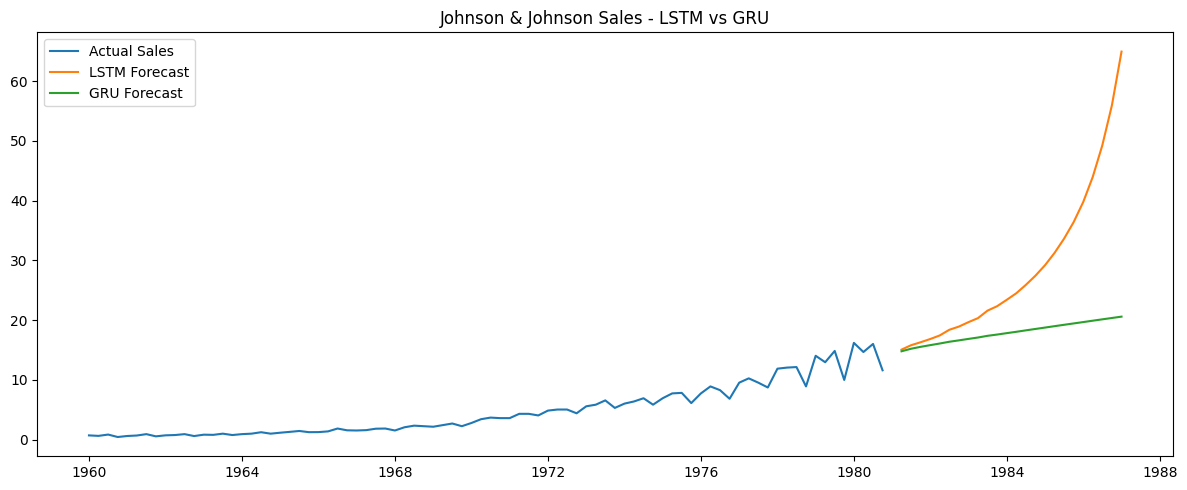

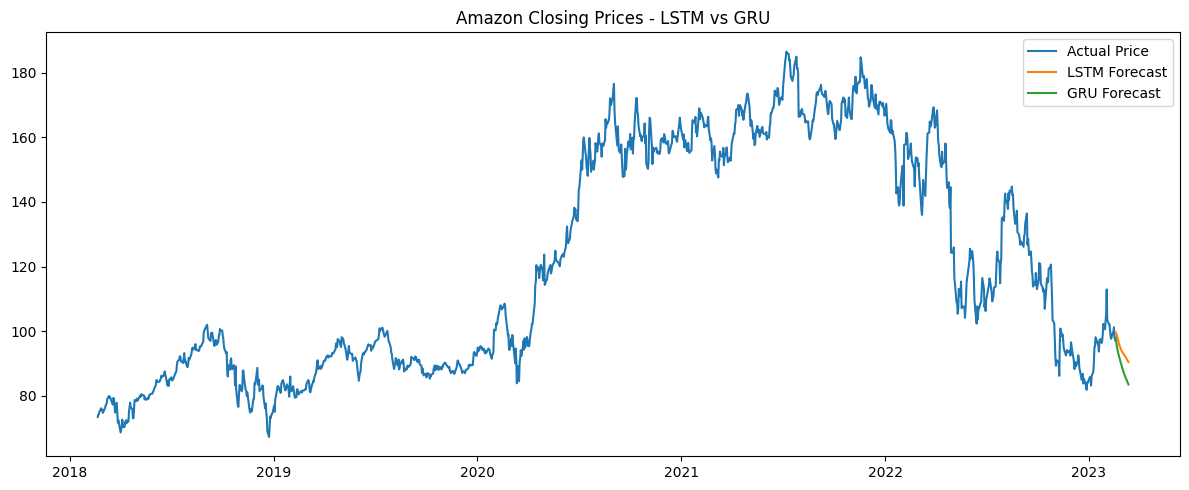

In [20]:


# Forecast 24 steps ahead using last known sequence
def forecast_rnn(model, last_seq, steps=24):
    forecast = []
    input_seq = last_seq.copy()
    for _ in range(steps):
        pred = model.predict(input_seq.reshape(1, -1, 1), verbose=0)[0, 0]
        forecast.append(pred)
        input_seq = np.append(input_seq[1:], pred)
    return np.array(forecast)

# Forecasts for JJ and AMZN using LSTM & GRU
lstm_jj_forecast = forecast_rnn(lstm_jj, X_jj[-1].flatten(), 24)
gru_jj_forecast = forecast_rnn(gru_jj, X_jj[-1].flatten(), 24)
lstm_amzn_forecast = forecast_rnn(lstm_amzn, X_amzn[-1].flatten(), 24)
gru_amzn_forecast = forecast_rnn(gru_amzn, X_amzn[-1].flatten(), 24)

# Inverse transform forecasts
lstm_jj_forecast = scaler_jj.inverse_transform(lstm_jj_forecast.reshape(-1, 1)).flatten()
gru_jj_forecast = scaler_jj.inverse_transform(gru_jj_forecast.reshape(-1, 1)).flatten()
lstm_amzn_forecast = scaler_amzn.inverse_transform(lstm_amzn_forecast.reshape(-1, 1)).flatten()
gru_amzn_forecast = scaler_amzn.inverse_transform(gru_amzn_forecast.reshape(-1, 1)).flatten()

# Plot forecasts
future_jj = pd.date_range(jj_df.index[-1], periods=25, freq='Q')[1:]
future_amzn = pd.date_range(amzn_df.index[-1], periods=25, freq='D')[1:]

plt.figure(figsize=(12, 5))
plt.plot(jj_df.index, jj_df["data"], label="Actual Sales")
plt.plot(future_jj, lstm_jj_forecast, label="LSTM Forecast")
plt.plot(future_jj, gru_jj_forecast, label="GRU Forecast")
plt.title("Johnson & Johnson Sales - LSTM vs GRU")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(amzn_df.index, amzn_df["Close"], label="Actual Price")
plt.plot(future_amzn, lstm_amzn_forecast, label="LSTM Forecast")
plt.plot(future_amzn, gru_amzn_forecast, label="GRU Forecast")
plt.title("Amazon Closing Prices - LSTM vs GRU")
plt.legend()
plt.tight_layout()
plt.show()